In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import slim
from tensorflow.contrib.slim import nets

In [2]:
# 字符集
CHAR_SET = [str(i) for i in "0123456789ABCDE"]
CHAR_SET_LEN = len(CHAR_SET)
print(CHAR_SET_LEN)
# 批次大小
BATCH_SIZE = 32
# tf文件
TFRECORD_TEST_FILE = 'captcha/tfrecords/test.tfrecord'

15


In [3]:
# 读取数据的函数
def read_and_decode(filename):
    tf_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(tf_queue)
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'image/encoded':tf.FixedLenFeature([], tf.string),
                                            'image/label0': tf.FixedLenFeature([], tf.int64),
                                            'image/label1': tf.FixedLenFeature([], tf.int64),
                                            'image/label2': tf.FixedLenFeature([], tf.int64),
                                            'image/label3': tf.FixedLenFeature([], tf.int64),
                                       })
    image = tf.decode_raw(features['image/encoded'], tf.uint8)
    image_raw = tf.reshape(image,[224,224,1])
    image = tf.cast(image_raw, tf.float32) / 255.0
    image = tf.subtract(image, 0.5)
    image = tf.multiply(image, 2.0)

    label0 = tf.cast(features['image/label0'], tf.int32)
    label1 = tf.cast(features['image/label1'], tf.int32)
    label2 = tf.cast(features['image/label2'], tf.int32)
    label3 = tf.cast(features['image/label3'], tf.int32)
    return image, image_raw, label0, label1, label2, label3

In [4]:
tf.reset_default_graph()

image,image_raw, label0, label1, label2, label3 = read_and_decode(TFRECORD_TEST_FILE)
image_batch, image_raw_batch, label0_batch, label1_batch, label2_batch, label3_batch = tf.train.shuffle_batch(
    [image, image_raw, label0, label1, label2, label3],
    batch_size=BATCH_SIZE,
    capacity=1000,
    min_after_dequeue=500,
    num_threads=1
)

# 网络 
x = tf.placeholder(tf.float32,[None,224,224,1])
y0 = tf.placeholder(tf.int32,[None])
y1 = tf.placeholder(tf.int32,[None])
y2 = tf.placeholder(tf.int32,[None])
y3 = tf.placeholder(tf.int32,[None])

with slim.arg_scope(nets.alexnet.alexnet_v2_arg_scope(weight_decay=0.0005)):
    outputs, end_points = nets.alexnet.alexnet_v2(x,CHAR_SET_LEN,is_training=False,dropout_keep_prob=1)
    #modify alexnet_v2
    fc7 = tf.get_default_graph().get_tensor_by_name("alexnet_v2/fc7/Relu:0")

    logits0 = tf.contrib.layers.conv2d(
            fc7,
            CHAR_SET_LEN, [1, 1],
            activation_fn=None,
            normalizer_fn=None,
            weights_initializer=tf.truncated_normal_initializer(0.0, 0.005),
            biases_initializer=tf.zeros_initializer(),
            scope='fc8-0')
    logits1 = tf.contrib.layers.conv2d(
            fc7,
            CHAR_SET_LEN, [1, 1],
            activation_fn=None,
            normalizer_fn=None,
            weights_initializer=tf.truncated_normal_initializer(0.0, 0.005),
            biases_initializer=tf.zeros_initializer(),
            scope='fc8-1')
    logits2 = tf.contrib.layers.conv2d(
            fc7,
            CHAR_SET_LEN, [1, 1],
            activation_fn=None,
            normalizer_fn=None,
            weights_initializer=tf.truncated_normal_initializer(0.0, 0.005),
            biases_initializer=tf.zeros_initializer(),
            scope='fc8-2')
    logits3 = tf.contrib.layers.conv2d(
            fc7,
            CHAR_SET_LEN, [1, 1],
            activation_fn=None,
            normalizer_fn=None,
            weights_initializer=tf.truncated_normal_initializer(0.0, 0.005),
            biases_initializer=tf.zeros_initializer(),
            scope='fc8-3')

logits0 = tf.squeeze(logits0, [1, 2], name='fc8-0/squeezed')
logits1 = tf.squeeze(logits1, [1, 2], name='fc8-1/squeezed')
logits2 = tf.squeeze(logits2, [1, 2], name='fc8-2/squeezed')
logits3 = tf.squeeze(logits3, [1, 2], name='fc8-3/squeezed')


# 预测结果
op_pre0 = tf.argmax(logits0, 1,output_type=tf.int32)
op_pre1 = tf.argmax(logits1, 1,output_type=tf.int32)
op_pre2 = tf.argmax(logits2, 1,output_type=tf.int32)
op_pre3 = tf.argmax(logits3, 1,output_type=tf.int32)

# 计算准确率
correct_pre0 = tf.cast(tf.equal(y0, op_pre0),tf.float32)
correct_pre1 = tf.cast(tf.equal(y1, op_pre1),tf.float32)
correct_pre2 = tf.cast(tf.equal(y2, op_pre2),tf.float32)
correct_pre3 = tf.cast(tf.equal(y3, op_pre3),tf.float32)
accuracy = tf.reduce_mean(correct_pre0*correct_pre1*correct_pre2*correct_pre3)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecor

INFO:tensorflow:Restoring parameters from captcha/model/crack_captcha.model-7014


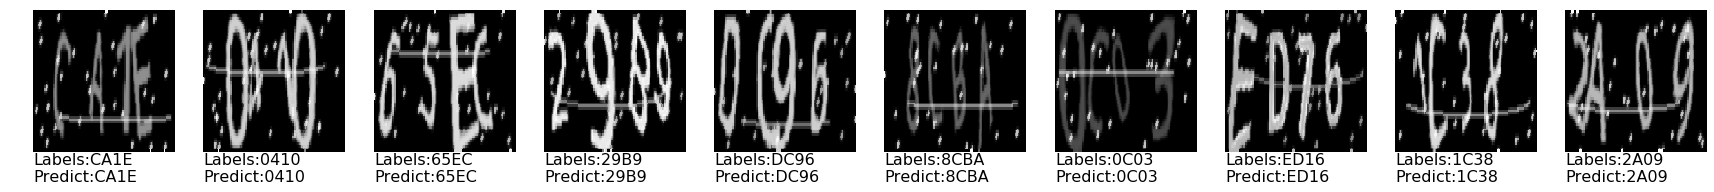

整体准确度： =  0.71875


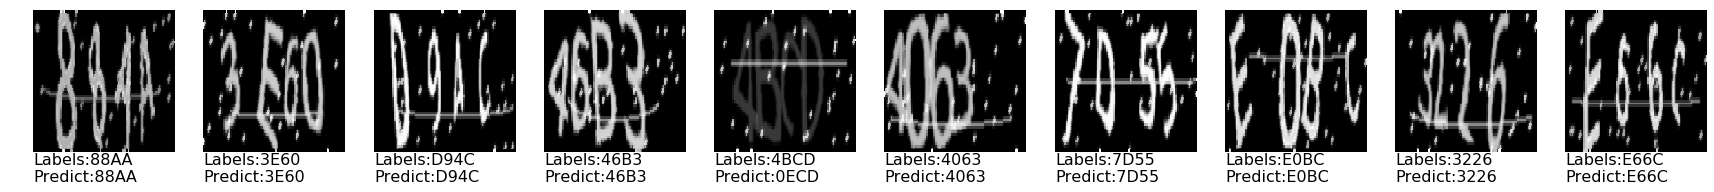

整体准确度： =  0.78125


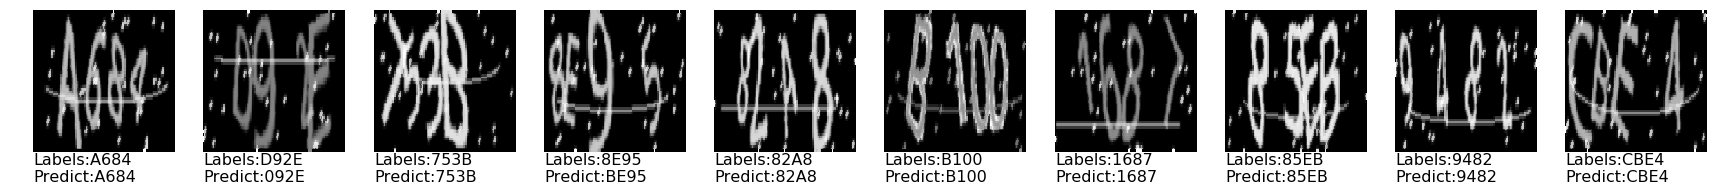

整体准确度： =  0.78125


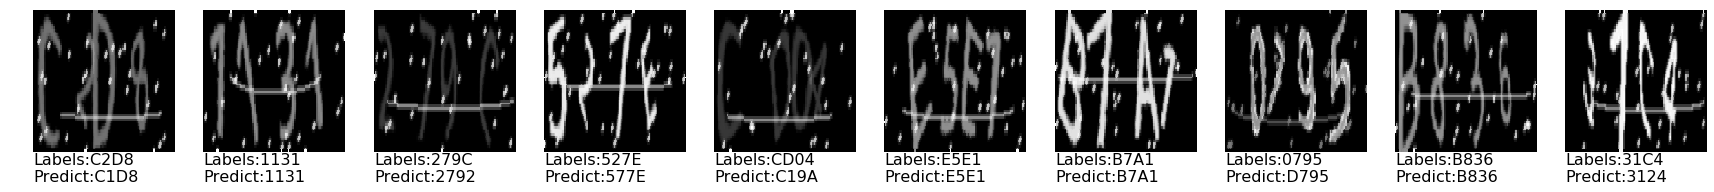

整体准确度： =  0.625


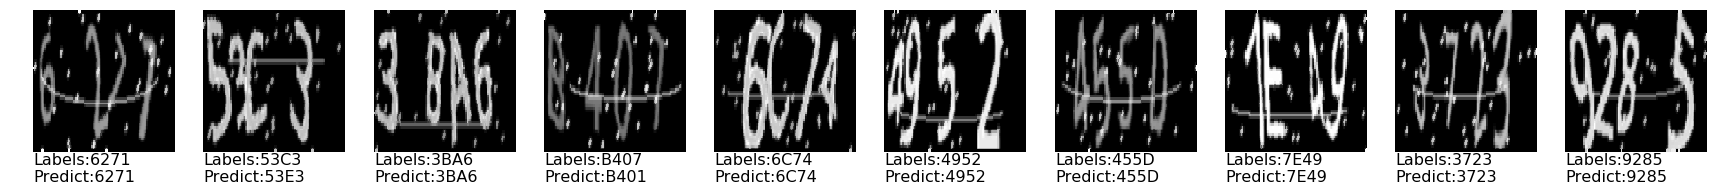

整体准确度： =  0.75


In [54]:
saver = tf.train.Saver()
SAMPLE_NUMS = 10
EPOCH = 5

SAMPLE_NUMS = min(SAMPLE_NUMS,BATCH_SIZE)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'captcha/model/crack_captcha.model-7014')
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    for i in np.arange(EPOCH):
        b_image, b_image_raw, b_label0, b_label1, b_label2, b_label3 = sess.run(
            [image_batch, image_raw_batch, label0_batch, label1_batch, label2_batch, label3_batch])
        
        correct_pre0,correct_pre1,correct_pre2,correct_pre3,accuracy_value = sess.run([op_pre0,op_pre1,op_pre2,op_pre3,accuracy],feed_dict={x:b_image,
                                                                                                                                           y0:b_label0,
                                                                                                                                           y1:b_label1,
                                                                                                                                           y2:b_label2,
                                                                                                                                           y3:b_label3})
        plt.figure(figsize=(30,5))
        for sampleIndex in np.arange(SAMPLE_NUMS):
            image_data = np.squeeze(b_image_raw[sampleIndex],2)
            ax = plt.subplot(1,SAMPLE_NUMS,sampleIndex+1)
            ax.imshow(image_data,cmap="binary")
            ax.axis("off")
            label_str = "Labels:{}{}{}{}\nPredict:{}{}{}{}".format(CHAR_SET[b_label0[sampleIndex]],CHAR_SET[b_label1[sampleIndex]],CHAR_SET[b_label2[sampleIndex]],CHAR_SET[b_label3[sampleIndex]],
                                                                   CHAR_SET[correct_pre0[sampleIndex]],CHAR_SET[correct_pre1[sampleIndex]],CHAR_SET[correct_pre2[sampleIndex]],CHAR_SET[correct_pre3[sampleIndex]])
            ax.text(0,270,label_str,fontsize=16)
        plt.show()
        print("整体准确度： = ",accuracy_value)
    coord.request_stop()
    coord.join(threads)